# Import packages

In [92]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
import patch_seq_spl.helper_functions as src
from importlib import reload
import json
import matplotlib.pyplot as plt
import seaborn as sns
from utility.ryp import r, to_r
import anndata

In [134]:
r(
"""
library(readr)
library(ggplot2)
library(magrittr)
library(dplyr)
library(tidyr)
"""
)


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [ ]:
reload(src)

<module 'patch_seq_spl.helper_functions' from '/gpfs/fs0/scratch/s/shreejoy/nxu/patch_seq_spl/patch_seq_spl/helper_functions.py'>

# Plotting

## Proportions of sig genes that are ion channels

In [80]:
glm_results = src.get_glm_results("proc/three/simple")
VGIC_LGIC = np.load("proc/VGIC_LGIC.npy", allow_pickle=True)
ephys_props = pd.read_csv("data/ephys_data_sc.csv", index_col = 0)

temp = []
for predictor in glm_results.columns:
    sig_genes = src.rank_introns_by_n_sig_corr(glm_results, predictor, "all").index.to_series().str.split("_", expand = True).iloc[:, 0].values
    sig_genes = np.unique(sig_genes)
    n_sig_gene_in_VGIC = len(np.intersect1d(sig_genes, VGIC_LGIC))
    n_sig_gene = len(sig_genes)
    ratio = n_sig_gene_in_VGIC / n_sig_gene
    temp.append(ratio)
VGIC_prop = pd.Series(temp, index = glm_results.columns, name = "proportion")\
    .to_frame()\
    .assign(type = lambda x: np.where(x.index.isin(ephys_props), "ephys", "categorical"))
VGIC_prop['type'] = VGIC_prop['type'].astype('category')

In [83]:
to_r(VGIC_prop, "VGIC_prop")

null device 
          1 


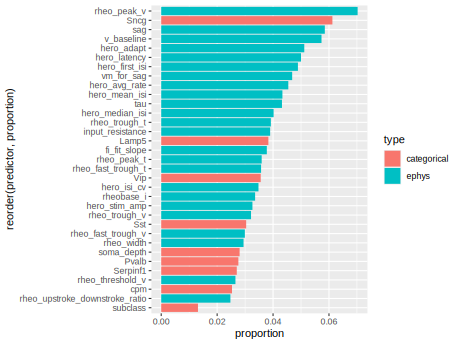

In [90]:
r(
"""
VGIC_prop %>% 
  as_tibble(rownames = "predictor") %>% 
  mutate(type = as.factor(type)) %>% 
  ggplot(aes(x = proportion, y = reorder(predictor, proportion), fill = type)) +
    geom_bar(stat = "identity")
"""
  )

## Number sig clusters that include at least one novel splice site

In [ ]:
adata = anndata.read_h5ad("proc/preprocessed_adata_three.h5ad")

novel_dict = adata.var\
    .assign(annotation = lambda x: x.annotation.apply({"0" : True, "1" : False}.get))\
    .groupby("intron_group")["annotation"].any().to_dict()

temp = glm_results\
    .applymap(lambda x: x < 0.05)\
    .assign(annotation = lambda x: x.index.map(novel_dict))\
    .groupby("annotation")\
    .sum().T\
    .rename(columns = {True : "novel", False : "known"})

to_r(temp, "temp")

/Users/xunuo/miniforge3/envs/patch_seq_spl/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


null device 
          1 


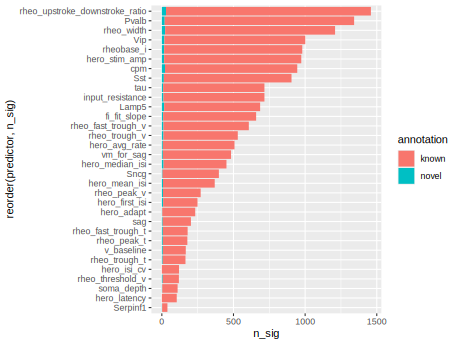

In [141]:
r(
"""
temp <- temp[-which(rownames(temp) == "subclass"), ]
temp %>%
    as_tibble(rownames = "predictor") %>%
    pivot_longer(cols = c("novel", "known"), names_to = "annotation", values_to = "n_sig") %>%
    ggplot(aes(x = n_sig, y = reorder(predictor, n_sig), fill = annotation)) +
        geom_bar(stat = "identity")
"""
)

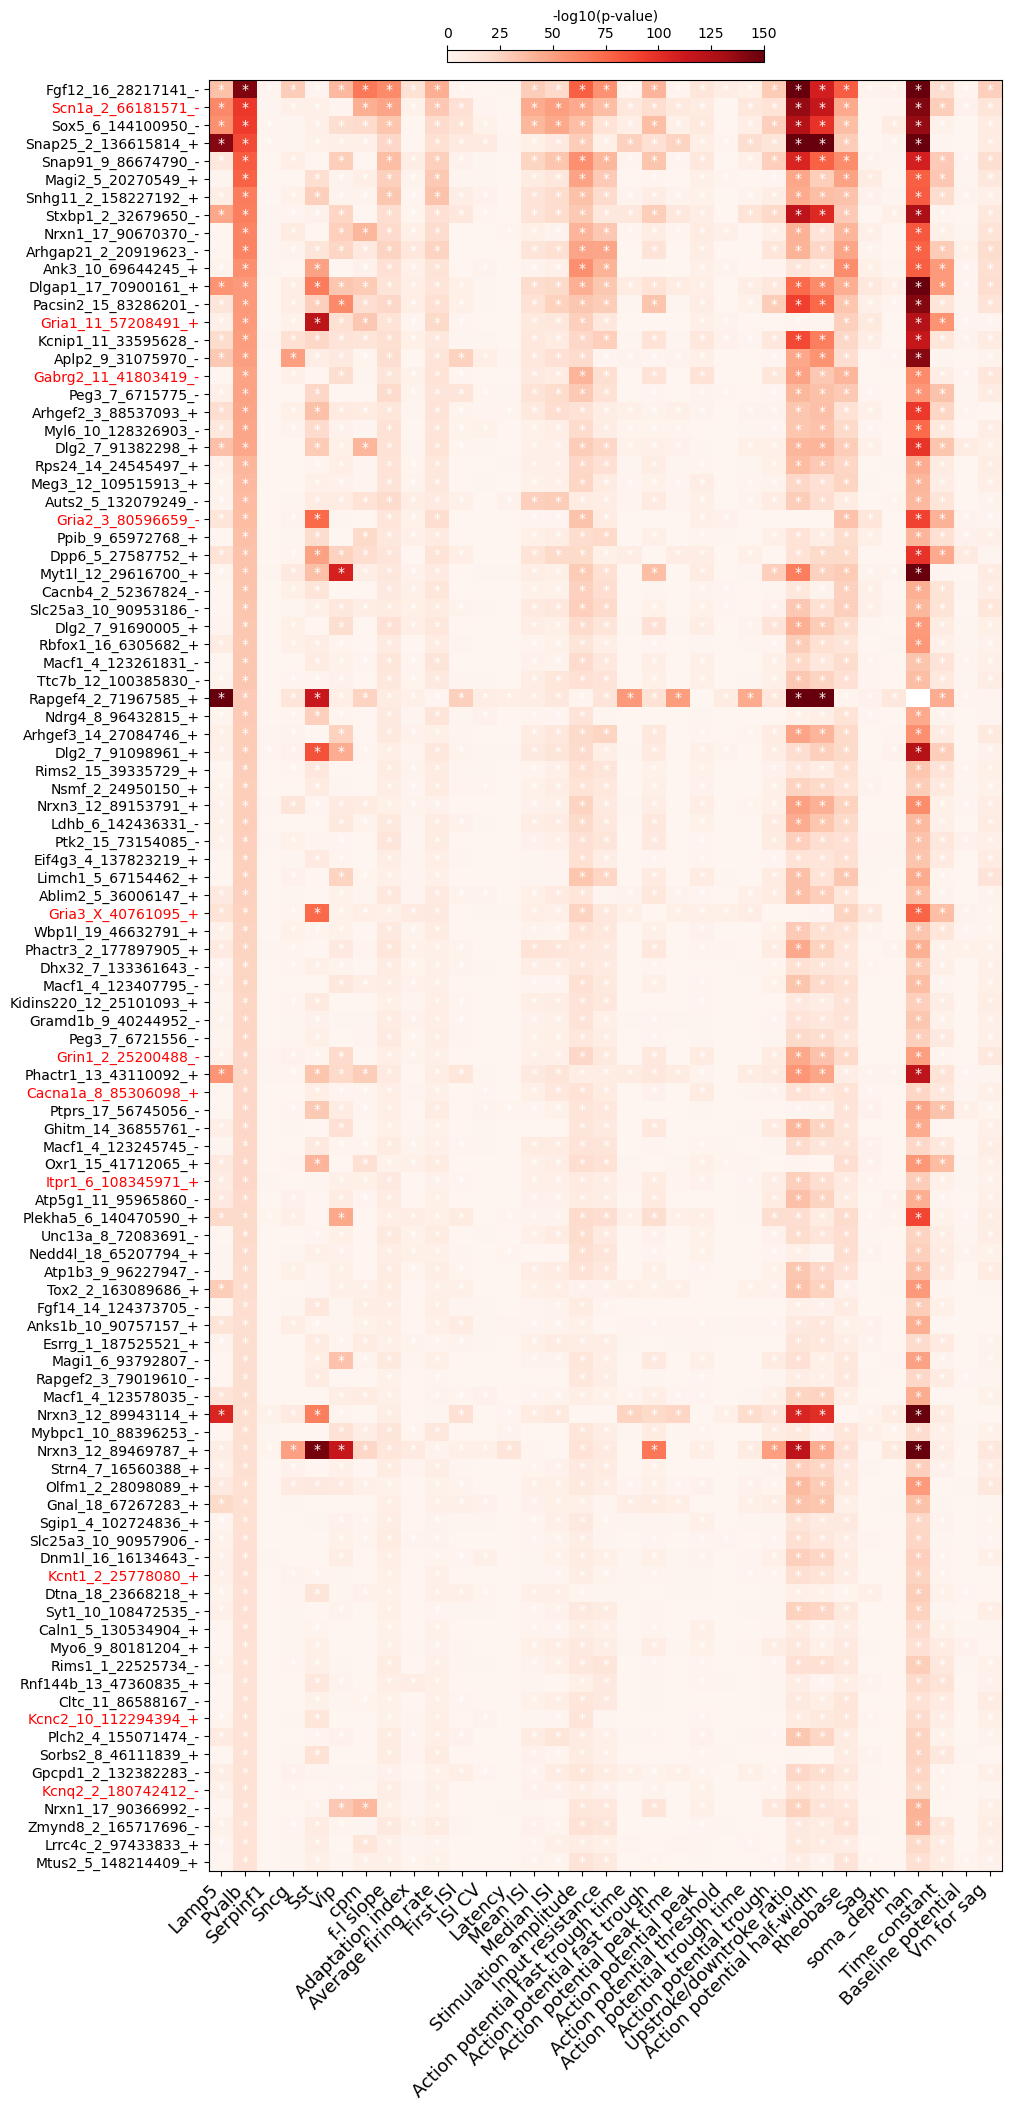

In [39]:
src.plot_glm_results_all("proc/three/simple", rank_by = "Pvalb")

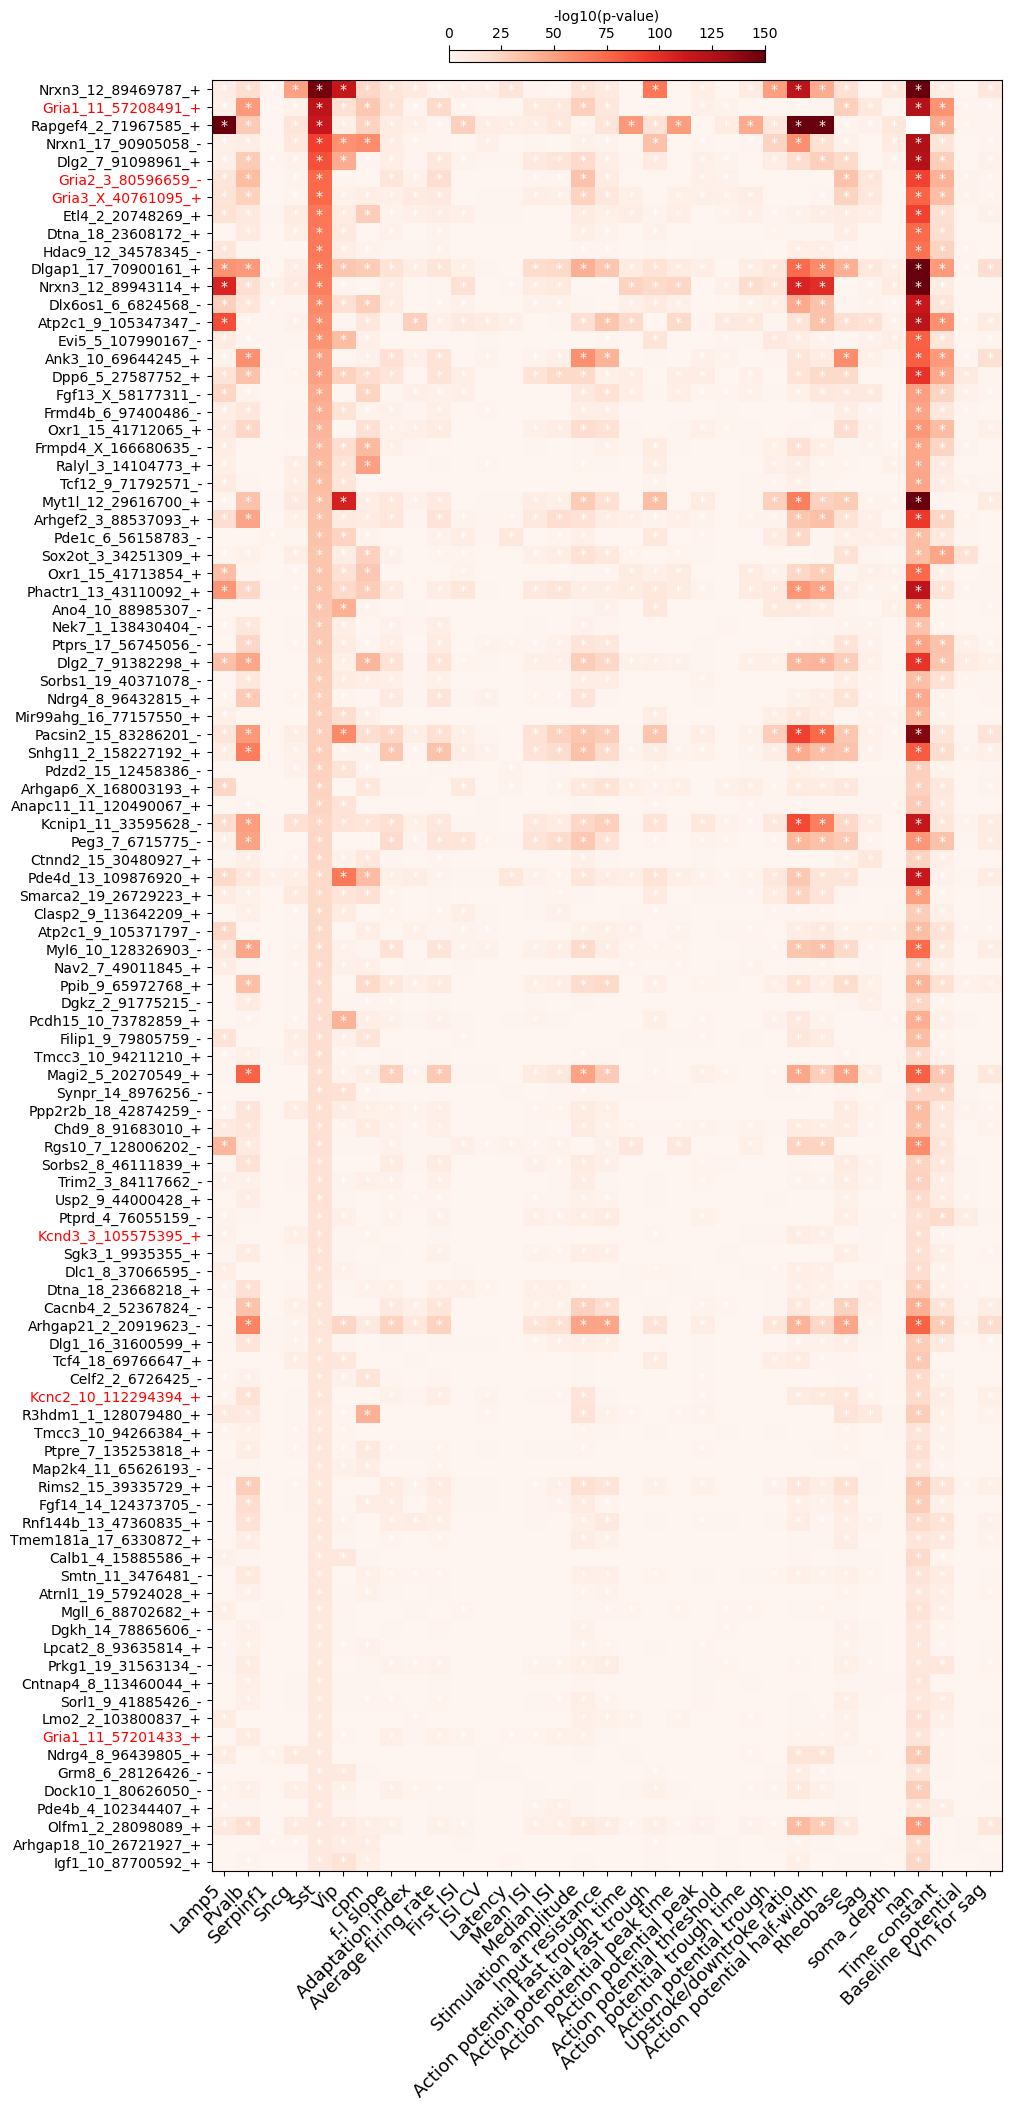

In [41]:
src.plot_glm_results_all("proc/three/simple", rank_by = "Sst")

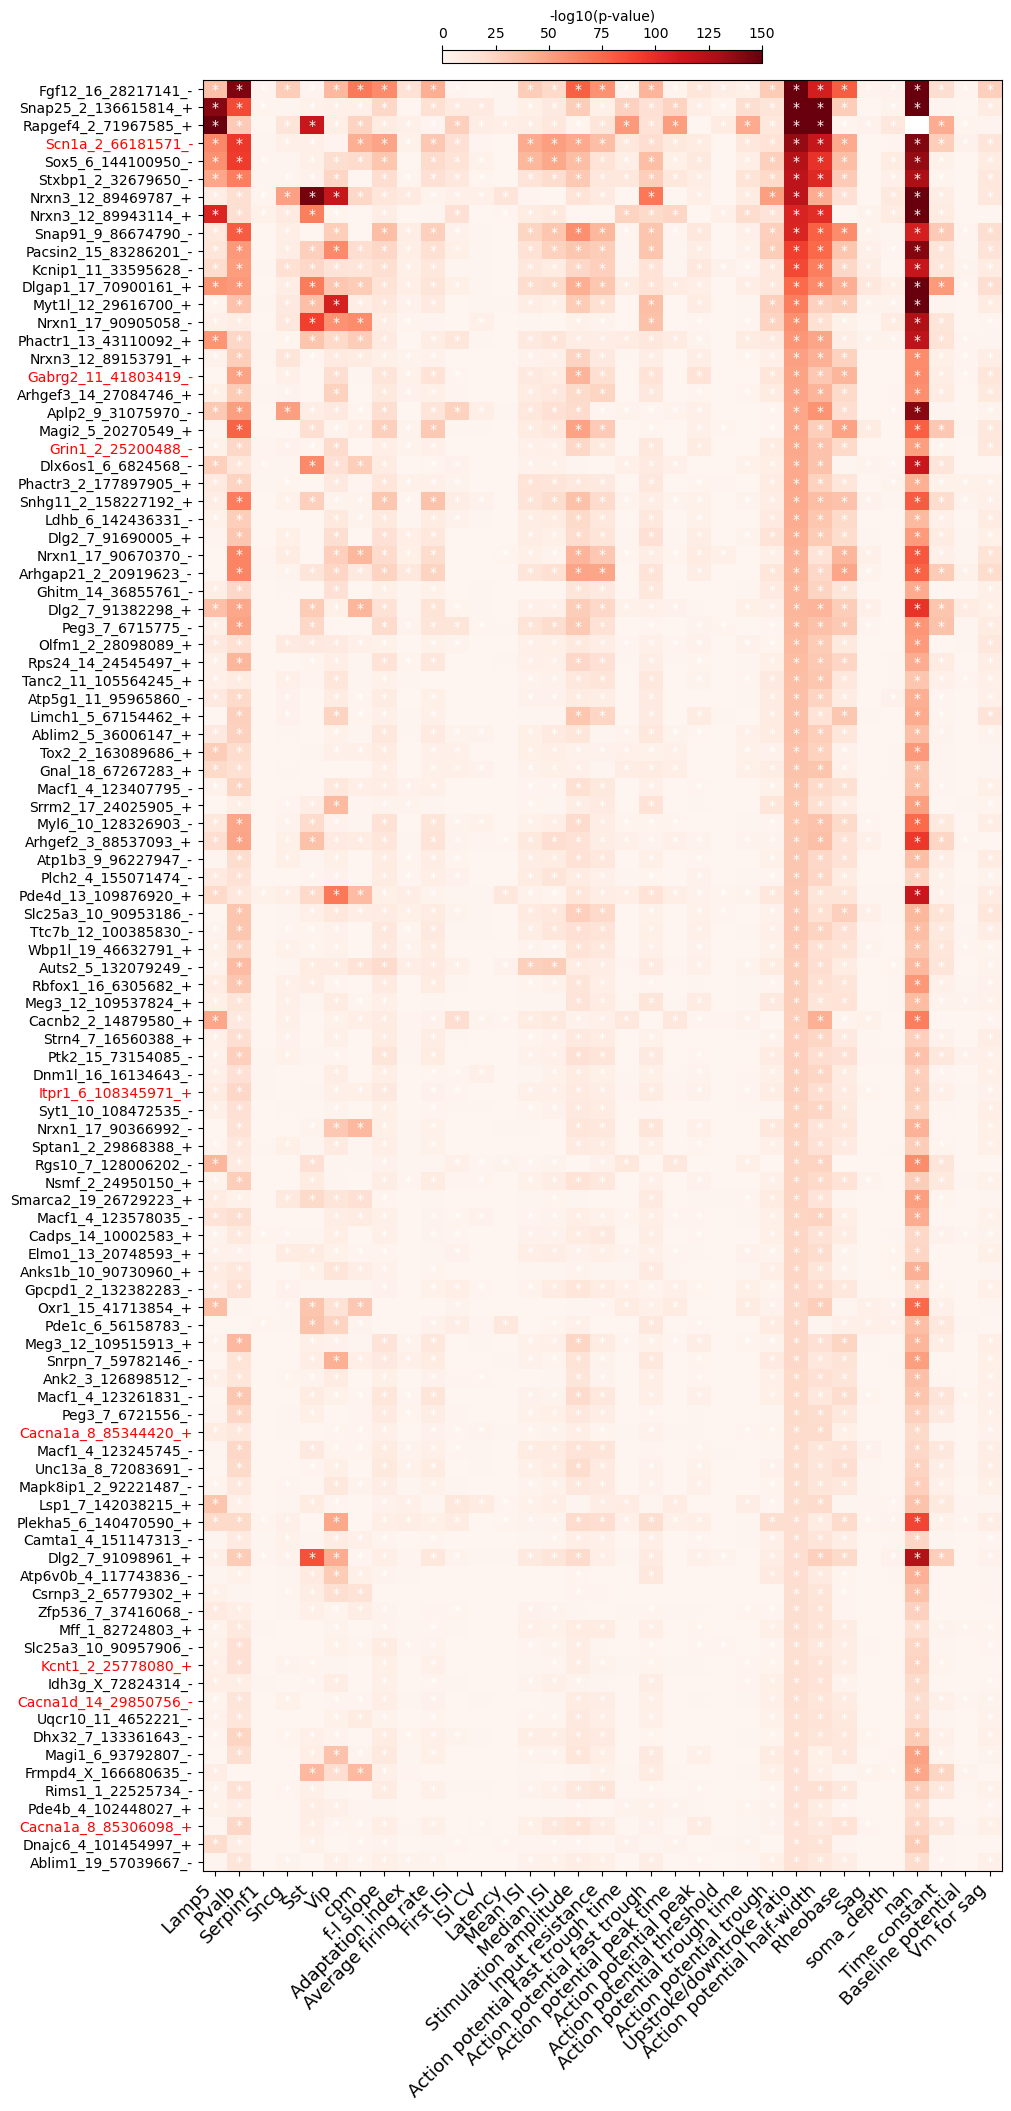

In [42]:
src.plot_glm_results_all("proc/three/simple", rank_by = "rheo_upstroke_downstroke_ratio")

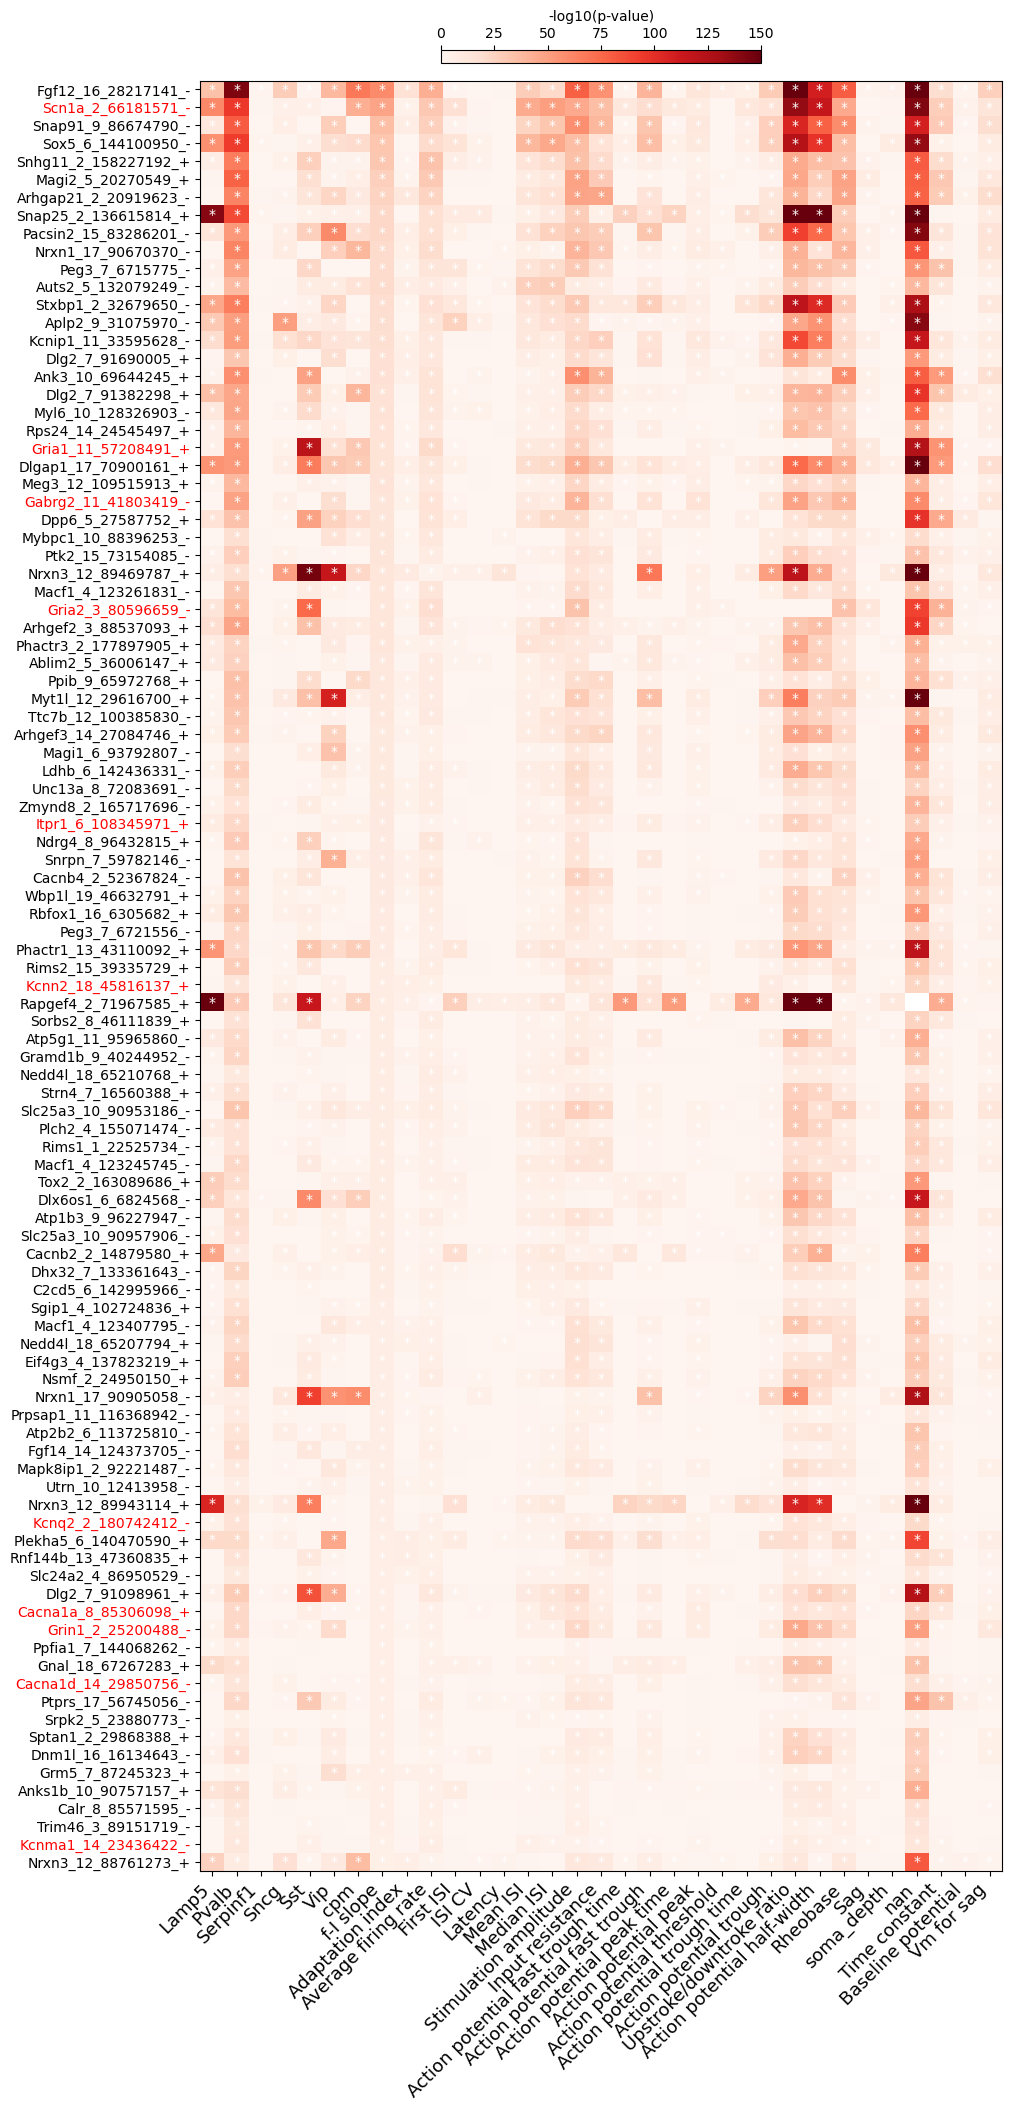

In [43]:
src.plot_glm_results_all("proc/three/simple", rank_by = "fi_fit_slope")

In [30]:
def rank_introns_by_n_sig_corr(glm_results, rank_by, top):
    '''
    Rank introns by the number of significant correlations

    Args:
        glm_results: pd.DataFrame
            glm_results
        rank_by: str
            column to rank by
            "all" would rank by the sum of significant correlations across columns
        top: int or "all"
    
    Returns:
        pd.DataFrame
            p_value_matrix
    '''
    if rank_by == "all":
        p_value_matrix = glm_results.loc[glm_results.apply(lambda x: (x < 0.05)).sum(axis = 1).sort_values(by = rank_by, ascending = False).index]
    else:
        p_value_matrix = glm_results.loc[glm_results[rank_by].sort_values(ascending = True).index]
    if isinstance(top, int):
        return p_value_matrix.iloc[:top]
    elif top == "all":
        p_value_matrix = p_value_matrix.loc[glm_results.apply(lambda x: (x < 0.05)).sum(axis = 1) > 0, :]
    return p_value_matrix

In [31]:
rank_introns_by_n_sig_corr(glm_results, "Vip", 200)

path                          Lamp5         Pvalb  Serpinf1          Sncg  \
intron_group                                                                
Nrxn3_12_89469787_+    2.417468e-08  6.293225e-19  0.013616  4.179222e-50   
Myt1l_12_29616700_+    5.133981e-03  3.243561e-34  0.119493  7.889942e-11   
Pde4d_13_109876920_+   8.793135e-23  1.072868e-12  0.000236  6.434705e-07   
Pacsin2_15_83286201_-  9.625860e-15  1.736593e-53  0.307059  3.593541e-08   
Nrxn1_17_90905058_-    5.664138e-06  6.268039e-08  0.706938  5.894517e-13   
...                             ...           ...       ...           ...   
Filip1_9_79805759_-    7.158144e-17  7.478202e-01  0.761443  1.148654e-07   
Cacnb3_15_98537368_+   1.435654e-03  6.143564e-01  0.978390  4.945335e-01   
Crlf1_8_70956470_+     5.203537e-01  3.523134e-02  0.967673  9.897305e-01   
Creb5_6_53581446_+     9.262566e-01  5.544950e-01  0.871351  6.892680e-01   
Cdh7_1_109921715_+     1.239818e-01  4.385513e-01  1.000000  1.911345e-01   

path                             Sst            Vip           cpm  \
intron_group                                                        
Nrxn3_12_89469787_+    3.953847e-146  2.153409e-116  5.787892e-24   
Myt1l_12_29616700_+     8.106096e-36  4.374461e-108  6.193857e-08   
Pde4d_13_109876920_+    7.161680e-23   4.641288e-69  1.151665e-37   
Pacsin2_15_83286201_-   3.197368e-27   9.850065e-61  2.446878e-20   
Nrxn1_17_90905058_-     1.726607e-92   9.414808e-57  1.789871e-59   
...                              ...            ...           ...   
Filip1_9_79805759_-     9.633537e-20   1.334307e-05  2.848054e-14   
Cacnb3_15_98537368_+    3.326628e-08   1.411025e-05  1.035689e-06   
Crlf1_8_70956470_+      4.642028e-02   1.491708e-05  1.301377e-06   
Creb5_6_53581446_+      1.874427e-02   1.597031e-05  8.228970e-01   
Cdh7_1_109921715_+      4.557633e-02   1.636679e-05  9.061203e-01   

path                   fi_fit_slope    hero_adapt  hero_avg_rate  ...  \
intron_group                                                      ...   
Nrxn3_12_89469787_+    4.442550e-14  3.921527e-10   1.291991e-03  ...   
Myt1l_12_29616700_+    8.417170e-13  1.024868e-03   2.579749e-10  ...   
Pde4d_13_109876920_+   2.006472e-06  7.985369e-08   1.484270e-03  ...   
Pacsin2_15_83286201_-  1.642491e-23  6.199506e-07   1.422561e-18  ...   
Nrxn1_17_90905058_-    9.461711e-08  8.328539e-03   5.928374e-02  ...   
...                             ...           ...            ...  ...   
Filip1_9_79805759_-    4.727480e-01  8.996601e-01   8.680187e-01  ...   
Cacnb3_15_98537368_+   8.306266e-01  5.144079e-01   1.972378e-01  ...   
Crlf1_8_70956470_+     9.705543e-02  9.534185e-01   3.379002e-01  ...   
Creb5_6_53581446_+     5.407662e-01  9.572643e-01   9.678567e-01  ...   
Cdh7_1_109921715_+     7.762243e-01  9.332187e-01   8.019272e-01  ...   

path                   rheo_trough_v  rheo_upstroke_downstroke_ratio  \
intron_group                                                           
Nrxn3_12_89469787_+     6.616371e-51                   7.980084e-120   
Myt1l_12_29616700_+     8.730029e-28                    5.641247e-66   
Pde4d_13_109876920_+    5.981838e-12                    1.900583e-31   
Pacsin2_15_83286201_-   5.554563e-29                    2.883968e-92   
Nrxn1_17_90905058_-     1.364089e-25                    4.168840e-58   
...                              ...                             ...   
Filip1_9_79805759_-     3.940826e-01                    3.164359e-12   
Cacnb3_15_98537368_+    4.064176e-01                    4.012818e-01   
Crlf1_8_70956470_+      1.192150e-01                    1.389033e-04   
Creb5_6_53581446_+      4.037205e-02                    2.590996e-04   
Cdh7_1_109921715_+      9.091485e-03                    1.791311e-02   

path                     rheo_width    rheobase_i       sag    soma_depth  \
intron_group                                                                
Nrxn3_12_89469787_+    2.994016e-44  8.175102e-18  0.981844

In [20]:
reload(src)

<module 'patch_seq_spl.helper_functions' from '/gpfs/fs0/scratch/s/shreejoy/nxu/patch_seq_spl/patch_seq_spl/helper_functions.py'>

In [ ]:
def rank_introns_by_n_sig_corr(glm_results, top):
    p_value_matrix = glm_results.loc[glm_results.apply(lambda x: (x < 0.05)).sum(axis = 1).sort_values(ascending = False).index]
    if isinstance(top, int):
        return p_value_matrix.iloc[:top]
    elif top == "all":
        p_value_matrix = p_value_matrix.loc[glm_results.apply(lambda x: (x < 0.05)).sum(axis = 1) > 0, :]
    return p_value_matrix

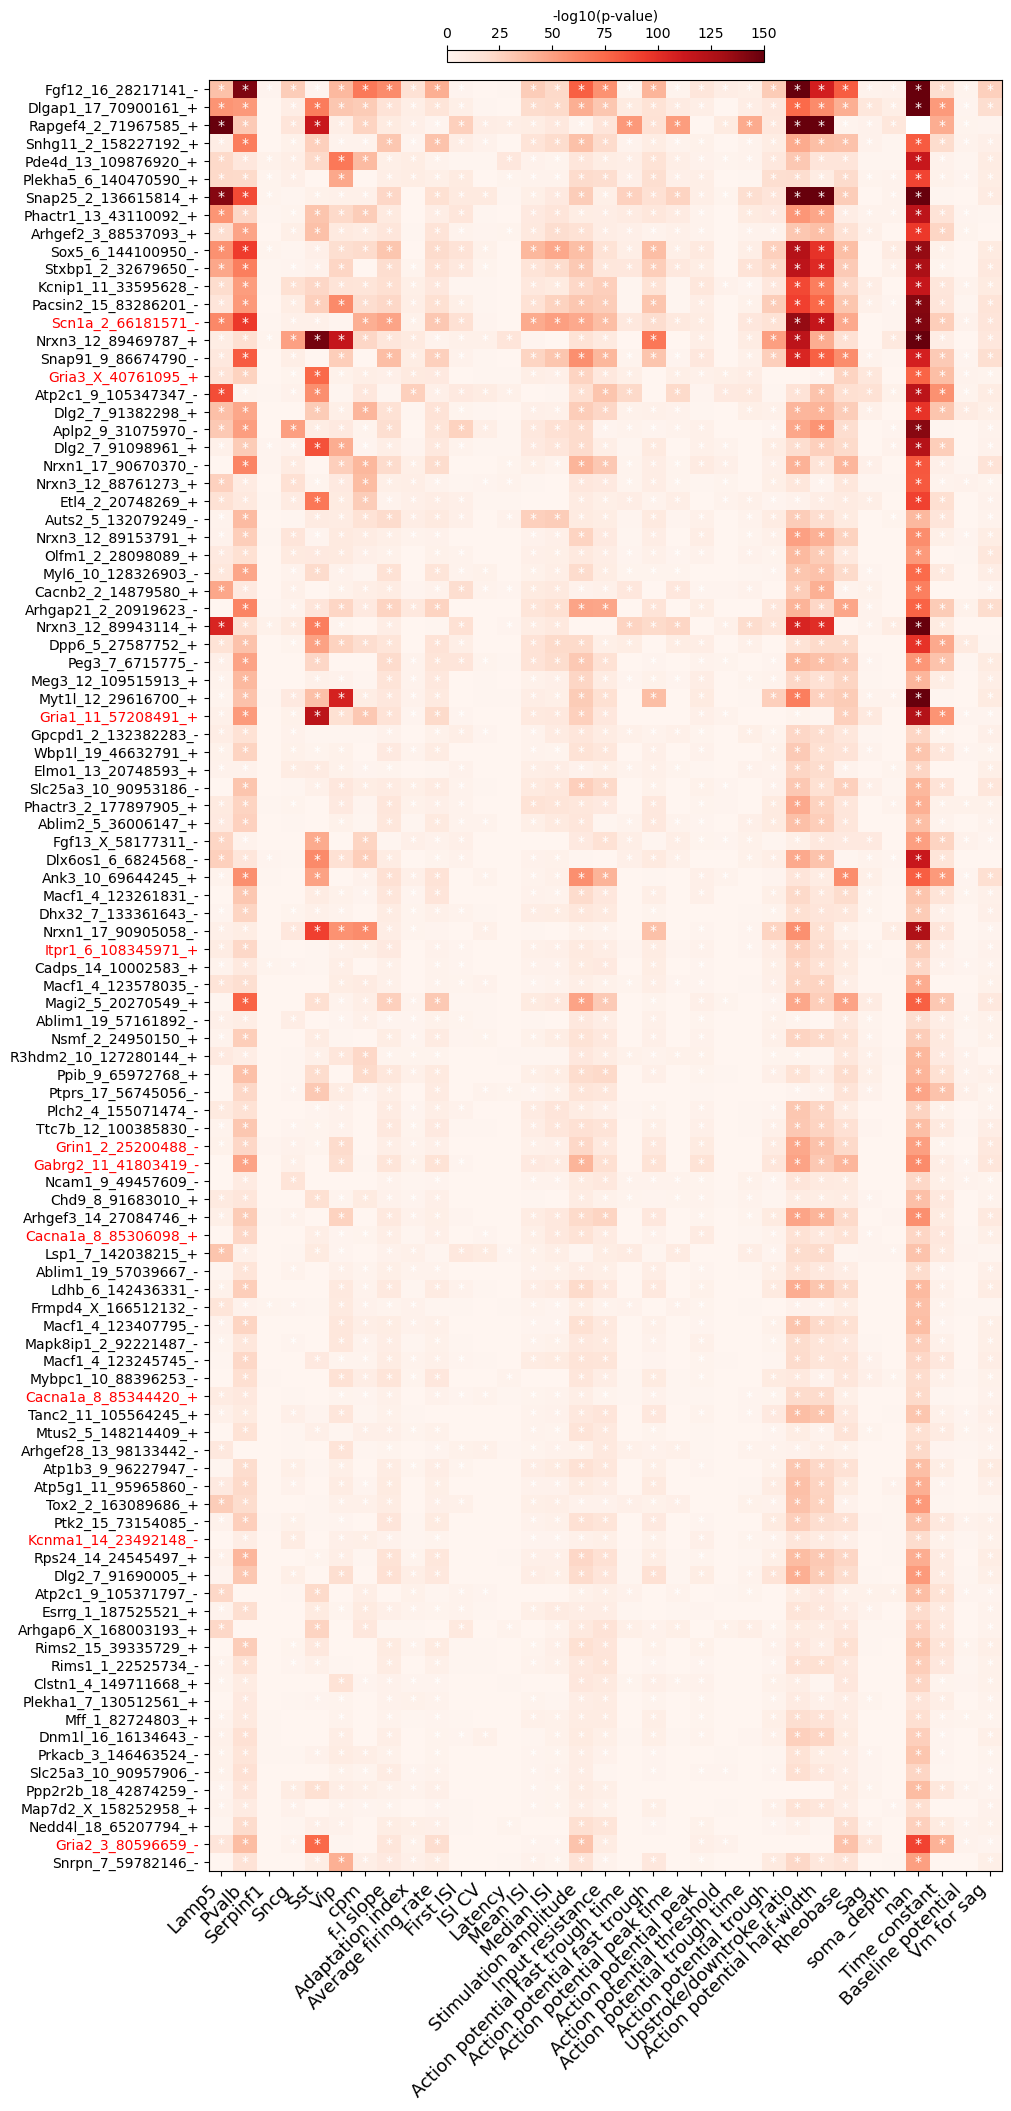

In [21]:
src.plot_glm_results_all("proc/three/simple")

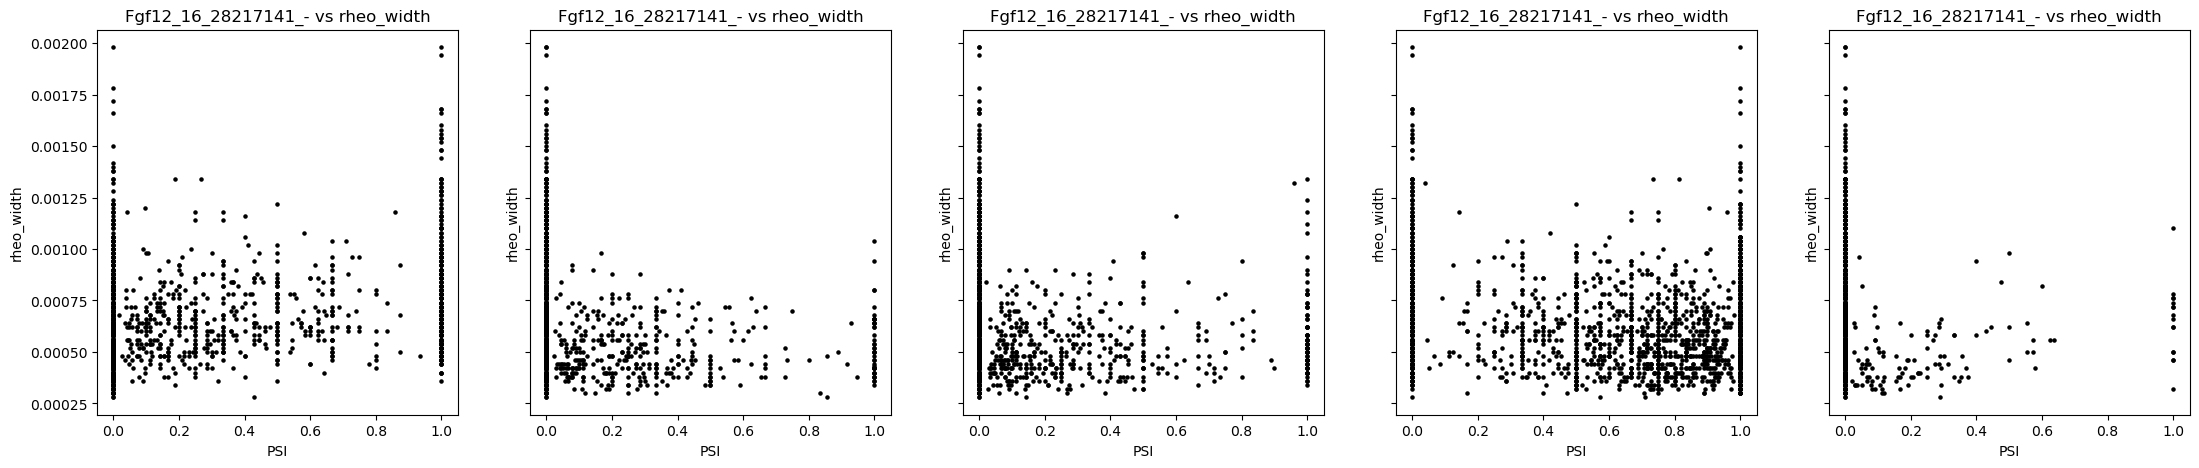

In [98]:
src.plot_intron_group_vs_ephys_prop(adata, "Fgf12_16_28217141_-", "rheo_width")

In [ ]:
transcriptomics_sample_id_file_name = json.load(open("data/mappings/transcriptomics_sample_id_file_name.json"))
cpm = pd.read_csv("data/20200513_Mouse_PatchSeq_Release_cpm.v2.csv", index_col = 0)
cpm = cpm.T
cpm.index = cpm.index.map(transcriptomics_sample_id_file_name)
cpm = cpm.reset_index().dropna(subset=["index"]).set_index("index") # drop NaN indices
ephys_data_sc = pd.read_csv("data/ephys_data_sc.csv", index_col = 0)
ephys_data_sc = ephys_data_sc.loc[(np.isnan(ephys_data_sc)).sum(axis = 1) < 6, :]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
ephys_data_sc = pd.DataFrame(imp.fit_transform(ephys_data_sc), index=ephys_data_sc.index, columns=ephys_data_sc.columns)
commin_ids = np.intersect1d(ephys_data_sc.index, cpm.index)
ephys_data_sc = ephys_data_sc.loc[commin_ids]
cpm = cpm.loc[commin_ids]
cpm = cpm.loc[:, cpm.sum(axis = 0) > 20]
gene_ephys_rank_p = correlate(cpm.values, ephys_data_sc.values, rank = True).p
gene_ephys_rank_p = correlate(cpm.values, ephys_data_sc.values, rank = True).p
gene_ephys_rank_p = pd.DataFrame(
    fdrcorrection(gene_ephys_rank_p.flatten())[1].reshape(gene_ephys_rank_p.shape), 
    index = cpm.columns, 
    columns = ephys_data_sc.columns)
top_100 = gene_ephys_rank_p.loc[gene_ephys_rank_p.apply(lambda x: (x < 0.05)).sum(axis = 1).sort_values(ascending = False)[:100].index]

: 

/scratch/s/shreejoy/nxu/patch_seq_spl/env/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


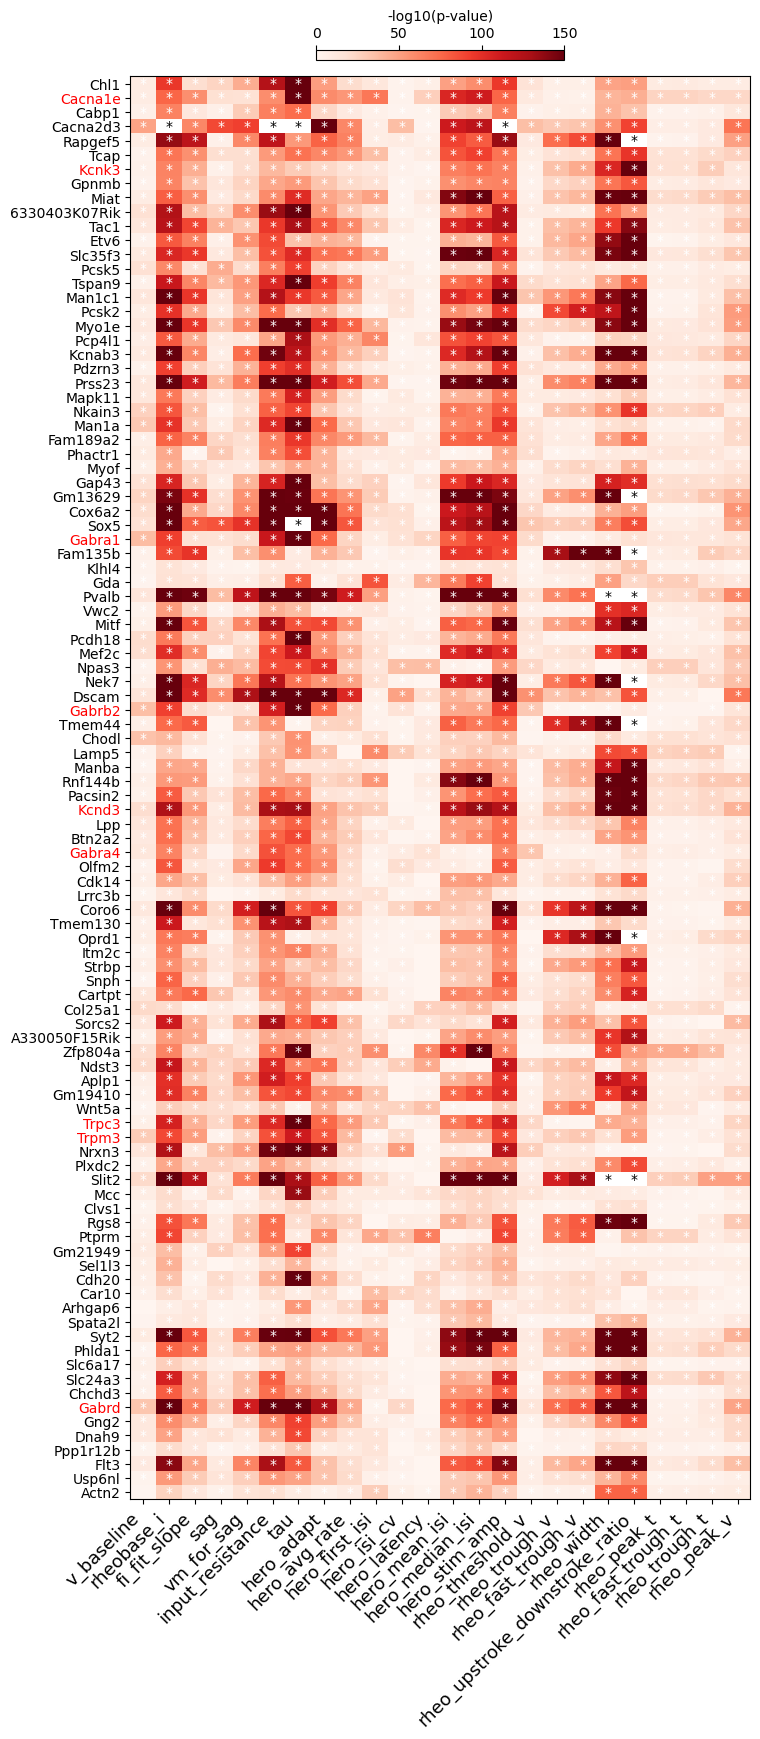

In [ ]:
VGIC_LGIC = np.load("proc/VGIC_LGIC.npy", allow_pickle= True)
top = 100
p_value_matrix = top_100
ephys_matrix = p_value_matrix

IC_idx = np.flatnonzero(np.isin(p_value_matrix.index, VGIC_LGIC))

# Plotting parameters
vmin=0
vmax=150
cmap = "Reds"
colorbar_label = "-log10(p-value)"
textcolors=("black", "white")
kw = dict(horizontalalignment="center", verticalalignment="center")

# Plotting starts here
fig, axs = plt.subplots(1, 1, figsize=(8, 2+1*5*(top/25)), sharey=True)
plt.subplots_adjust(wspace=0.05)

im = axs.imshow(-np.log10(p_value_matrix), aspect="auto", cmap = cmap, vmin = vmin, vmax = vmax)
axs.set_xticks(np.arange(len(p_value_matrix.columns)))
axs.set_yticks(np.arange(len(p_value_matrix.index)))
axs.set_xticklabels(p_value_matrix.columns, rotation=45, ha='right', fontsize = 13)

# setting yticklabels
yticklabels = p_value_matrix.index.to_list()
y_labels = axs.get_yticklabels()
for i in IC_idx:
    y_labels[i].set_color("red")
axs.set_yticklabels(yticklabels)

# add asteriks to significant correlations
fdr = np.vectorize({True: "*", False: " "}.get)(p_value_matrix< 0.05)
texts = []
for i in range(fdr.shape[0]):
    for j in range(fdr.shape[1]):
        kw.update(color=textcolors[int(im.norm(p_value_matrix.iloc[i, j]) > 0)])
        text = im.axes.text(j, i, fdr[i, j], **kw)
        texts.append(text) 
        
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin = vmin, vmax = vmax), 
            cmap=cmap), ax=axs, shrink=0.4, aspect = 25, location = "top", 
            pad = 0.01, label = colorbar_label)

# FGF12

 FGF12 (FHF1) gene encodes voltage-gated sodium channel (Nav)-binding protein fibroblast growth factor homologous factor 1, which could cause seizures by regulating voltage dependence of Nav fast inactivation and neuron excitability. The most common pathogenic variant FGF12 c.341G > A related early-onset epileptic encephalopathies (EOEE) was characterized by intractable seizures and developmental disabilities.  FGF12 (FHF1) gene encodes voltage-gated sodium channel (Nav)-binding protein fibroblast growth factor homologous factor 1, which could cause seizures by regulating voltage dependence of Nav fast inactivation and neuron excitability. The most common pathogenic variant FGF12 c.341G > A related early-onset epileptic encephalopathies (EOEE) was characterized by intractable seizures and developmental disabilities. 
 
 Physiologically, FGF12 is expressed in two different transcripts resulting from alternative splicing, which differ only in their N-terminal part. Our results demonstrated that the expression of WTA, with its longer N-terminal part, has a stronger effect on the fast inactivation of NaV1.6 than WTB with its shorter N-terminal part, which is in line with previous studies.

# Gene expression-level

In [ ]:
transcriptomics_sample_id_file_name = json.load(open("data/mappings/transcriptomics_sample_id_file_name.json"))
cpm = pd.read_csv("data/20200513_Mouse_PatchSeq_Release_cpm.v2.csv", index_col = 0)
cpm = cpm.T
cpm.index = cpm.index.map(transcriptomics_sample_id_file_name)
cpm = cpm.reset_index().dropna(subset=["index"]).set_index("index") # drop NaN indices
ephys_data_sc = pd.read_csv("data/ephys_data_sc.csv", index_col = 0)
ephys_data_sc = ephys_data_sc.loc[(np.isnan(ephys_data_sc)).sum(axis = 1) < 6, :]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
ephys_data_sc = pd.DataFrame(imp.fit_transform(ephys_data_sc), index=ephys_data_sc.index, columns=ephys_data_sc.columns)
commin_ids = np.intersect1d(ephys_data_sc.index, cpm.index)
ephys_data_sc = ephys_data_sc.loc[commin_ids]
cpm = cpm.loc[commin_ids]
cpm = cpm.loc[:, cpm.sum(axis = 0) > 20]
gene_ephys_rank_p = correlate(cpm.values, ephys_data_sc.values, rank = True).p
gene_ephys_rank_p = correlate(cpm.values, ephys_data_sc.values, rank = True).p
gene_ephys_rank_p = pd.DataFrame(
    fdrcorrection(gene_ephys_rank_p.flatten())[1].reshape(gene_ephys_rank_p.shape), 
    index = cpm.columns, 
    columns = ephys_data_sc.columns)
top_100 = gene_ephys_rank_p.loc[gene_ephys_rank_p.apply(lambda x: (x < 0.05)).sum(axis = 1).sort_values(ascending = False)[:100].index]

: 

/scratch/s/shreejoy/nxu/patch_seq_spl/env/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


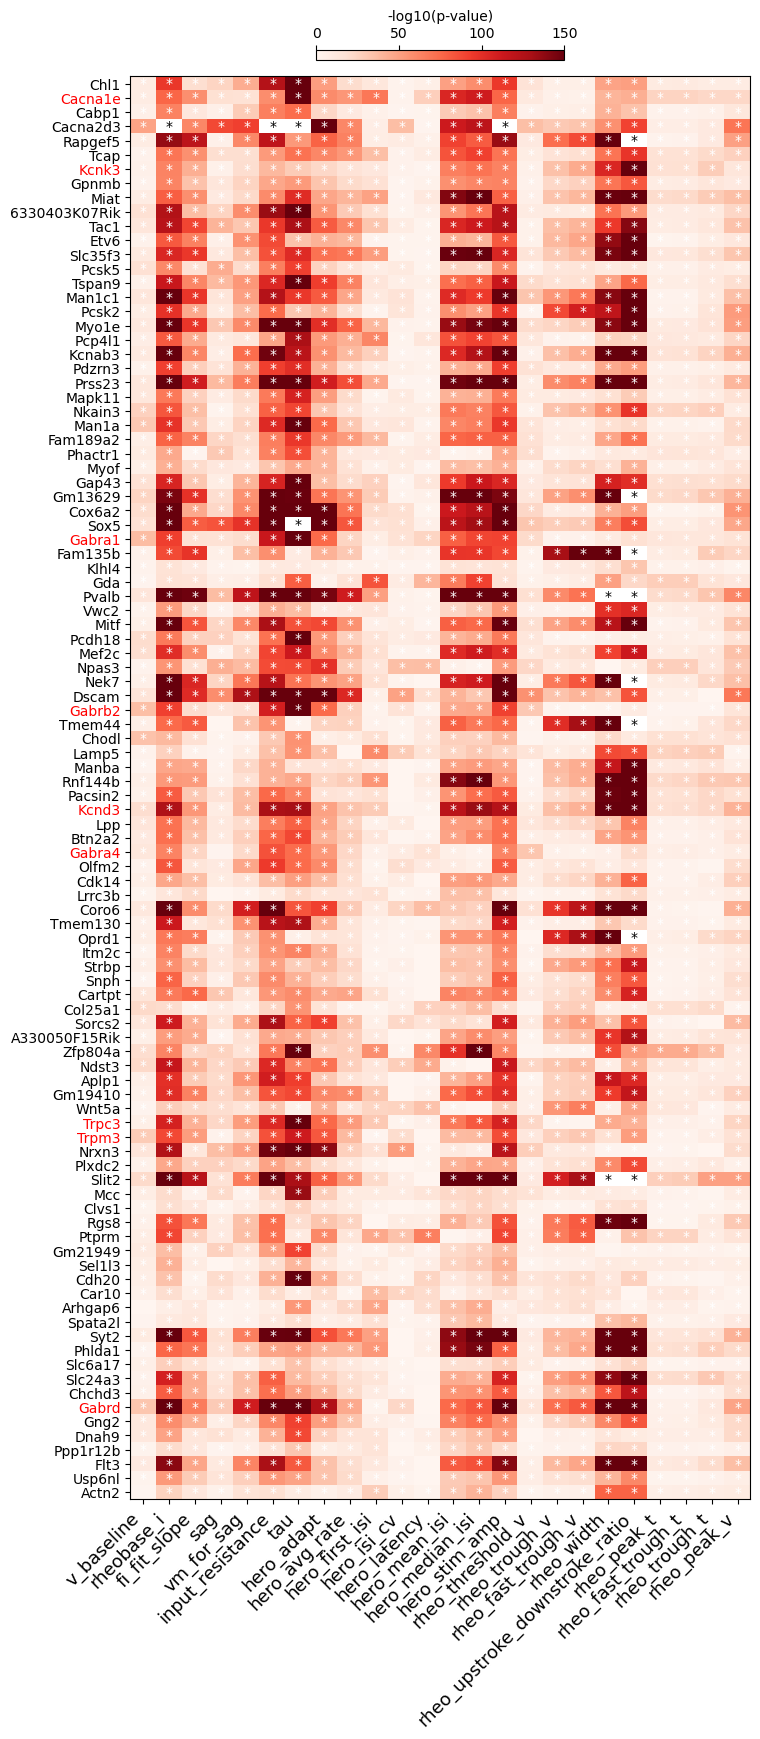

In [ ]:
VGIC_LGIC = np.load("proc/VGIC_LGIC.npy", allow_pickle= True)
top = 100
p_value_matrix = top_100
ephys_matrix = p_value_matrix

IC_idx = np.flatnonzero(np.isin(p_value_matrix.index, VGIC_LGIC))

# Plotting parameters
vmin=0
vmax=150
cmap = "Reds"
colorbar_label = "-log10(p-value)"
textcolors=("black", "white")
kw = dict(horizontalalignment="center", verticalalignment="center")

# Plotting starts here
fig, axs = plt.subplots(1, 1, figsize=(8, 2+1*5*(top/25)), sharey=True)
plt.subplots_adjust(wspace=0.05)

im = axs.imshow(-np.log10(p_value_matrix), aspect="auto", cmap = cmap, vmin = vmin, vmax = vmax)
axs.set_xticks(np.arange(len(p_value_matrix.columns)))
axs.set_yticks(np.arange(len(p_value_matrix.index)))
axs.set_xticklabels(p_value_matrix.columns, rotation=45, ha='right', fontsize = 13)

# setting yticklabels
yticklabels = p_value_matrix.index.to_list()
y_labels = axs.get_yticklabels()
for i in IC_idx:
    y_labels[i].set_color("red")
axs.set_yticklabels(yticklabels)

# add asteriks to significant correlations
fdr = np.vectorize({True: "*", False: " "}.get)(p_value_matrix< 0.05)
texts = []
for i in range(fdr.shape[0]):
    for j in range(fdr.shape[1]):
        kw.update(color=textcolors[int(im.norm(p_value_matrix.iloc[i, j]) > 0)])
        text = im.axes.text(j, i, fdr[i, j], **kw)
        texts.append(text) 
        
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin = vmin, vmax = vmax), 
            cmap=cmap), ax=axs, shrink=0.4, aspect = 25, location = "top", 
            pad = 0.01, label = colorbar_label)